In [1]:
# Load the dataset from google drive
# Unzip the dataset from google drive to Colab machine
import zipfile
from google.colab import drive
import os

drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/My Drive/Colab Notebooks/Dataset/Dataset.zip", 'r')
zip_ref.extractall("/content/Dataset")
zip_ref.close()

if os.path.exists('/content/drive/My Drive/Colab Notebooks/Dataset/Training.npz'):
  !cp "/content/drive/My Drive/Colab Notebooks/Dataset/Training.npz" '/content/Dataset/Training.npz'
  !cp "/content/drive/My Drive/Colab Notebooks/Dataset/Test.npz" '/content/Dataset/Test.npz'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
# copy the preprocessd dataset save in npz file from the colab to google drive
from google.colab import drive
drive.mount('/content/drive/')
!cp 'Dataset/Test.npz' "/content/drive/My Drive/Colab Notebooks/Dataset"
!cp 'Dataset/Training.npz' "/content/drive/My Drive/Colab Notebooks/Dataset"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
# check the gpu information
# Tesla K80 is the best one in colab
!nvidia-smi            

Mon Apr 20 17:56:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

(31367, 3, 48, 48)
(7842, 3, 48, 48)
(31367, 43)
(7842, 43)
BPNN:
Train on 31367 samples, validate on 7842 samples
Epoch 1/5
31367/31367 [==============================] - 15s 483us/sample - loss: 0.3748 - acc: 0.8935 - val_loss: 0.1630 - val_acc: 0.9522 - lr: 0.0100
Epoch 2/5
31367/31367 [==============================] - 13s 412us/sample - loss: 0.0803 - acc: 0.9756 - val_loss: 0.0857 - val_acc: 0.9733 - lr: 0.0100
Epoch 3/5
31367/31367 [==============================] - 13s 414us/sample - loss: 0.0451 - acc: 0.9870 - val_loss: 0.0615 - val_acc: 0.9828 - lr: 0.0100
Epoch 4/5
31367/31367 [==============================] - 13s 415us/sample - loss: 0.0300 - acc: 0.9913 - val_loss: 0.0580 - val_acc: 0.9839 - lr: 0.0100
Epoch 5/5
31367/31367 [==============================] - 12s 396us/sample - loss: 0.0148 - acc: 0.9958 - val_loss: 0.0704 - val_acc: 0.9800 - lr: 0.0100
Accuracy on development set: 0.9990688184670499
CNN: {'Conv_Layer': (32, 3), 'Conv_Overlap': False, 'Dropout_Conv': -1, 

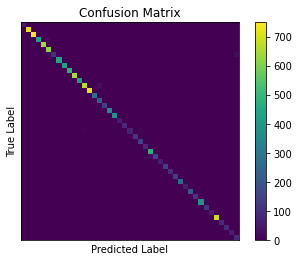

precision on test set: 0.9804020331235772
recall on test set: 0.9768294996861732
f1 on test set: 0.9774262802846536


In [23]:
from datetime import datetime
import numpy as np
from skimage import color, exposure, transform, io
import PIL
import os
import glob

# The ways to run 1.X code in TensorFlow 2.0
try: 
  import tensorflow.compat.v1 as tf
  tf.disable_v2_behavior()
except:
  import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.layers.core import Dense, Dropout, Activation, Flatten
from tensorflow.python.keras.layers.convolutional import Conv2D
from tensorflow.python.keras.layers.pooling import MaxPooling2D
from tensorflow.python.keras.models import load_model

from tensorflow.python.keras.optimizers import SGD
from tensorflow.python.keras.callbacks import LearningRateScheduler, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# Ref from: https://www.kaggle.com/questions-and-answers/125283
# Use the injection to avoid AttributeError: module 'tensorflow_core._api.v2.config'
# has no attribute 'experimental_list_devices' in windows system.
from tensorflow.python.keras import backend as K

K.set_image_data_format('channels_first')
try:
    import winsound
except ImportError:
    pass
else:
    import K.tensorflow_backend as tfback

    def _get_available_gpus():
        if tfback._LOCAL_DEVICES is None:
            devices = tf.config.list_logical_devices()
            tfback._LOCAL_DEVICES = [x.name for x in devices]
        return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]


    tfback._get_available_gpus = _get_available_gpus

import pandas as pd
from matplotlib import pyplot as plt

num_classes = 43
img_size = 48

path_training = r'Dataset/Final_Training/Images/'
path_test = r'Dataset/Final_Test/Images/'
path_test_csv = 'Dataset/GT-final_test.csv'
start_time = datetime.now()
# num_classes=6;path_training=r'Dataset/Final_Training_Small/Images/' # Small training set for test

# Preprocess function
def image_process(path, status_training, status_roi=True):
    global df
    # Get the Y value
    if status_training:
        label = int(path.split('/')[-2])
    else:
        label = int(df['ClassId'])

    img = PIL.Image.open(path)

    # plt.imshow(img)
    # plt.show()
    # Get the cropped image using Roi information
    if status_roi:
        box = (int(df['Roi.X1']), int(df['Roi.Y1']), int(df['Roi.X2']), int(df['Roi.Y2']))
        img = img.crop(box)

    # Implement the histogram equalization to get better image performance
    hsv = color.rgb2hsv(img)
    hsv[:, :, 2] = exposure.equalize_hist(hsv[:, :, 2])
    img = color.hsv2rgb(hsv)

    # Rescale the image to standard size
    img = transform.resize(img, (img_size, img_size))

    # roll color axis to axis 0
    img = np.rollaxis(img, -1)
    return img, label

# Load the training set
if os.path.exists('Dataset/Training.npz'):
    Training=np.load('Dataset/Training.npz')
    X = Training['X_train']
    Y = Training['Y_train']
else:
    imgs = []
    labels = []
    all_csv_paths = glob.glob(os.path.join(path_training, '*/*.csv'))  # Get all the csv file within the path

    for i, value in enumerate(all_csv_paths):
        all_csv_paths[i] = value.replace('\\', '/')

    for csv_path in all_csv_paths:  # Preprocess each image
        csv_file = pd.read_csv(csv_path, sep=';')
        for i in range(len(csv_file)):
            df = csv_file.loc[i]
            path = csv_path[:csv_path.rfind('/') + 1] + df['Filename']
            if os.path.exists(path):  # For Small training set, if the file exists
                img, label = (image_process(path, status_training=True))
                labels.append(label)
                imgs.append(img)

    X = np.array(imgs, dtype='float32')
    Y = np.eye(num_classes, dtype='uint8')[labels]  # Get one hot targets array
    if not os.path.exists('Dataset'):
        os.makedirs('Dataset')
    np.savez('Dataset/Training.npz',X_train=X,Y_train=Y)
    print(datetime.now() - start_time)

# Split the training set into training set and development set with the split ratio 80:20
X_train, X_dev, Y_train, Y_dev = train_test_split(X,Y,test_size=0.2, random_state=42)
print(X_train.shape)
print(X_dev.shape)
print(Y_train.shape)
print(Y_dev.shape)

# Load the test set
if os.path.exists('Dataset/Test.npz'):
    Test=np.load('Dataset/Test.npz')
    X_test = Test['X_test']
    Y_test = Test['Y_test']
else:
    labels = []
    imgs = []
    X_test = []
    Y_test = []
    test_file = pd.read_csv(path_test_csv, sep=';')
    for i in range(len(test_file)):
        df = test_file.loc[i]
        path = path_test + df['Filename']
        img, label = (image_process(path, status_training=False))
        imgs.append(img)
        labels.append(label)
    X_test = np.array(imgs, dtype='float32')
    Y_test = np.eye(num_classes, dtype='uint8')[labels]
    if not os.path.exists('Dataset'):
        os.makedirs('Dataset')
    np.savez('Dataset/Test.npz',X_test=X_test,Y_test=Y_test)
    print(datetime.now() - start_time)

# Define the bp neutral network model
def bpnn_model():
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(3,img_size,img_size)))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

# Define the cnn model
def cnn_model(parameter_list):
    model = Sequential()
    filter=parameter_list['Conv_Layer'][0]
    layer=parameter_list['Conv_Layer'][1]
    
    for i in range(layer):
        if i==0:
            if parameter_list['Conv_Overlap']:
                # filters, kernel size，padding，input data，activation function
                model.add(Conv2D(filter, (3, 3), padding='same',
                                 input_shape=(3, img_size, img_size),
                                 activation='relu'))
                model.add(Conv2D(filter, (3, 3), activation='relu'))
            else:
                model.add(Conv2D(filter, (3, 3), padding='same',
                                 input_shape=(3, img_size, img_size),
                                 activation='relu'))
        else:    
            if parameter_list['Conv_Overlap']:
                # filters, kernel size，padding，input data，activation function
                model.add(Conv2D(filter, (3, 3), padding='same',
                                 activation='relu'))
                model.add(Conv2D(filter, (3, 3), activation='relu'))
            else:
                model.add(Conv2D(filter, (3, 3), padding='same',
                                 activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        if parameter_list['Dropout_Conv']!=-1:
            model.add(Dropout(parameter_list['Dropout_Conv']))
        filter=filter*2

    model.add(Flatten())

    units=parameter_list['Dense'][0]
    layer=parameter_list['Dense'][1]
    for i in range(layer):
        model.add(Dense(units))
        if parameter_list['BN']:
          model.add(BatchNormalization())
        model.add(Activation('relu'))
        if parameter_list['Dropout_Dense']!=-1:
            model.add(Dropout(parameter_list['Dropout_Dense']))

    model.add(Dense(num_classes, activation='softmax'))
    return model

# Calculate the learning rate during each epoch
def lr_schedule(epoch):
    return lr * (0.1 ** int(epoch / 10))

# Train the model using SGD + momentum
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)

# Function to compile the model
def model_compile():
    global model
    model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])
    
# Function to train the model
def model_train(batch_size,epoch,test=False):
    global model
    if test:
      validation_set=(X_test,Y_test)
    else:
      validation_set=(X_dev,Y_dev)     
    history = model.fit(X_train, Y_train,
                        batch_size=batch_size,
                        epochs=epoch,
                        validation_data=validation_set,
                        shuffle=True,
                        callbacks=[LearningRateScheduler(lr_schedule),
                                   # Save the best epoch report into model.h5
                                   ModelCheckpoint('Model.h5', save_best_only=True)]
                        # h5 is the format for keras to save the model
                        )
    return history

def plot_confusion_matrix(con_matrix): #Visualization of confusion matrix
    plt.imshow(con_matrix)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    labels = []
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


# Function to clear the model after using
def model_clear():
  global model
  #K.clear_session()
  #tf.reset_default_graph()
  del model

# Function to predict the model
# Get the performance on the test set
def model_predict(test=False):
    global model
    if test:
        Y_pred = np.eye(num_classes, dtype='uint8')[model.predict_classes(X_test)]
        acc = np.sum(Y_pred == Y_test) / np.size(Y_pred)

        print("Accuracy on test set: {}".format(acc))
        
        con_matrix = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))

        
        FP = con_matrix.sum(axis=0) - np.diag(con_matrix)  
        FN = con_matrix.sum(axis=1) - np.diag(con_matrix)
        TP = np.diag(con_matrix)
        TN = con_matrix.sum() - (FP + FN + TP)
        print(FP,FN,TP,TN)


        
        print("confusion_matrix on test set: {}".format(con_matrix))
        plot_confusion_matrix(con_matrix)
        precision = precision_score(Y_test.argmax(axis=1), Y_pred.argmax(axis=1),average='macro')
        print("precision on test set: {}".format(precision))
        recall = recall_score(Y_test.argmax(axis=1), Y_pred.argmax(axis=1),average='macro')
        f1=f1_score(Y_test.argmax(axis=1), Y_pred.argmax(axis=1),average='macro')
        
        print("recall on test set: {}".format(recall))
        print("f1 on test set: {}".format(f1))
        
        #con_mat=confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))
        
        #con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]    
        
        #print(con_mat_norm) #confusion matrix
    else:
        Y_pred = np.eye(num_classes, dtype='uint8')[model.predict_classes(X_dev)]
        acc = np.sum(Y_pred == Y_dev) / np.size(Y_pred)
        print("Accuracy on development set: {}".format(acc))

# The whole process of training the model
def model_process(batch_size,epoch,test=False):
    global model
    model_compile()
    model_train(batch_size=batch_size,epoch=epoch,test=test)
    model_predict(test)
    model_clear()


# Train the bp neutral network model
print('BPNN:')
model = bpnn_model()
model_process(batch_size=32,epoch=5)

batch_size=32
epoch=5

# Try the CNN model without dropout layer
parameter_list={'Conv_Layer':(32,3),'Conv_Overlap':False,
                'Dropout_Conv':-1,'Dense':(512,1),'Dropout_Dense':-1,'BN':False}
print('CNN: '+str(parameter_list))
model=cnn_model(parameter_list)
model_process(batch_size=batch_size,epoch=epoch)

# Try the CNN model with dropout layer
parameter_list={'Conv_Layer':(32,3),'Conv_Overlap':False,
                'Dropout_Conv':0.2,'Dense':(512,1),'Dropout_Dense':0.5,'BN':False}
print('CNN: '+str(parameter_list))
model=cnn_model(parameter_list)
model_process(batch_size=batch_size,epoch=epoch)

# Try the CNN model with deeper convolutional layer
parameter_list={'Conv_Layer':(32,5),'Conv_Overlap':False,
                'Dropout_Conv':0.2,'Dense':(512,1),'Dropout_Dense':0.5,'BN':False}
print('CNN: '+str(parameter_list))
model=cnn_model(parameter_list)
model_process(batch_size=batch_size,epoch=epoch)

# Try the CNN model with deeper hidden layer
parameter_list={'Conv_Layer':(32,5),'Conv_Overlap':False,
                'Dropout_Conv':0.2,'Dense':(512,3),'Dropout_Dense':0.5,'BN':False}
print('CNN: '+str(parameter_list))
model=cnn_model(parameter_list)
model_process(batch_size=batch_size,epoch=epoch)

# Try the CNN model with Two convolutional layers together
parameter_list={'Conv_Layer':(32,3),'Conv_Overlap':True,
                'Dropout_Conv':0.2,'Dense':(512,1),'Dropout_Dense':0.5,'BN':False}
print('CNN: '+str(parameter_list))
model=cnn_model(parameter_list)
model_process(batch_size=batch_size,epoch=epoch)

# Try the CNN model with different dropout probability
parameter_list={'Conv_Layer':(32,3),'Conv_Overlap':True,
                'Dropout_Conv':0.5,'Dense':(512,1),'Dropout_Dense':0.5,'BN':False}
print('CNN: '+str(parameter_list))
model=cnn_model(parameter_list)
model_process(batch_size=batch_size,epoch=epoch)

# Try the CNN model with different dropout probability
parameter_list={'Conv_Layer':(32,3),'Conv_Overlap':True,
                'Dropout_Conv':0.2,'Dense':(512,1),'Dropout_Dense':0.2,'BN':False}
print('CNN: '+str(parameter_list))
model=cnn_model(parameter_list)
model_process(batch_size=batch_size,epoch=epoch)

# Try the CNN model with batch normalisation
parameter_list={'Conv_Layer':(32,3),'Conv_Overlap':True,
                'Dropout_Conv':0.2,'Dense':(512,1),'Dropout_Dense':0.5,'BN':True}
print('CNN: '+str(parameter_list))
model=cnn_model(parameter_list)
model_process(batch_size=batch_size,epoch=epoch)

# Try the CNN model with different batch sizes
batch_size=16
epoch=5
parameter_list={'Conv_Layer':(32,3),'Conv_Overlap':True,
                'Dropout_Conv':0.2,'Dense':(512,1),'Dropout_Dense':0.5,'BN':False}
print('CNN: '+str(parameter_list))
print('Batch size=',batch_size)
model=cnn_model(parameter_list)
model_process(batch_size=batch_size,epoch=epoch)

batch_size=64
parameter_list={'Conv_Layer':(32,3),'Conv_Overlap':True,
                'Dropout_Conv':0.2,'Dense':(512,1),'Dropout_Dense':0.5,'BN':False}
print('CNN: '+str(parameter_list))
print('Batch size=',batch_size)
model=cnn_model(parameter_list)
model_process(batch_size=batch_size,epoch=epoch)

batch_size=256
parameter_list={'Conv_Layer':(32,3),'Conv_Overlap':True,
                'Dropout_Conv':0.2,'Dense':(512,1),'Dropout_Dense':0.5,'BN':False}
print('CNN: '+str(parameter_list))
print('Batch size=',batch_size)
model=cnn_model(parameter_list)
model_process(batch_size=batch_size,epoch=epoch)

# Get the performance on test set using 30 epoches and the selected best model
# Set the training set back to full
X_train=X
Y_train=Y
batch_size=32
epoch=30
parameter_list={'Conv_Layer':(32,3),'Conv_Overlap':True,
                'Dropout_Conv':0.2,'Dense':(512,1),'Dropout_Dense':0.5,'BN':False}
print('CNN: '+str(parameter_list))
model=cnn_model(parameter_list)
model_process(batch_size=batch_size,epoch=epoch,test=True)             

In [24]:
from keras.preprocessing.image import ImageDataGenerator

#Data Augmentation
datagen = ImageDataGenerator(featurewise_center=False, 
                            featurewise_std_normalization=False, 
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.2,
                            horizontal_flip=True,
                            rotation_range=10.,)

datagen.fit(X_train)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:940: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (39209, 3, 48, 48) (48 channels).
  ' channels).')


CNN: {'Conv_Layer': (32, 3), 'Conv_Overlap': True, 'Dropout_Conv': 0.2, 'Dense': (512, 1), 'Dropout_Dense': 0.5, 'BN': False}
Instructions for updating:
Please use Model.fit, which supports generators.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (39209, 3, 48, 48) (48 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/30
1/0 [======================================================================================================================================================] - 5s 5s/step - loss: 3.7590 - acc: 0.0312 - val_loss: 3.7533 - val_acc: 0.0600 - lr: 0.0100
Epoch 2/30
1/0 [======================================================================================================================================================] - 2s 2s/step - loss: 3.7628 - acc: 0.0000e+00 - val_loss: 3.7513 - val_acc: 0.0678 - lr: 0.0100
Epoch 3/30
1/0 [======================================================================================================================================================] - 3s 3s/step - loss: 3.7419 - acc: 0.0625 - val_loss: 3.7489 - val_acc: 0.0701 - lr: 0.0100
Epoch 4/30
1/0 [======================================================================================================================================================] - 2s 2s/step - loss: 3.7238 - acc: 0.0312 - val_

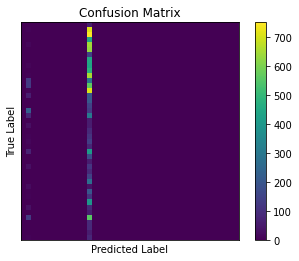

precision on test set: 0.0016035844835994531
recall on test set: 0.023191214470284237
f1 on test set: 0.002893955316658324


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
#after Data Augmentation
def model_train2(batch_size,epoch):
    global model
    history = model.fit_generator(datagen.flow(X_train, Y_train,batch_size=batch_size),
                                  epochs=epoch,
                                  steps_per_epoch=0.2,
                                  validation_data=(X_test,Y_test),
                                  shuffle=True,
                                  callbacks=[LearningRateScheduler(lr_schedule),
                                             ModelCheckpoint('Model.h5', save_best_only=True)]
                                  )
    return history

def model_process2(batch_size,epoch,test=False):
    global model
    model_compile()
    model_train2(batch_size=batch_size,epoch=epoch)
    model_predict(test)
    model_clear()

# Get the performance on test set using 30 epoches and the selected best model
# Set the training set back to full
X_train=X
Y_train=Y
batch_size=32
epoch=30
parameter_list={'Conv_Layer':(32,3),'Conv_Overlap':True,
                'Dropout_Conv':0.2,'Dense':(512,1),'Dropout_Dense':0.5,'BN':False}
print('CNN: '+str(parameter_list))
model=cnn_model(parameter_list)
model_process2(batch_size=batch_size,epoch=epoch,test=True)         